In [165]:
# Initial imports
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn import svm
import hvplot.pandas
import re
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import TimeSeriesSplit 
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
import warnings
warnings.filterwarnings('ignore')


# Pull in data and set some initial variables.

In [166]:
# Read in the daily data - Pulled from https://coincodex.com/crypto/bitcoin/historical-data/ 
data_path = Path("bitcoin_2010-8-16_2021-10-6.csv")
ohlcvm_df = pd.read_csv(
    data_path,
    index_col="Date",
    infer_datetime_format=True,
    parse_dates=True
)

ohlcvm_df.sort_index(ascending=True, inplace=True)

# Set initial capital for your portfolio
initial_capital = float(3000)

# Set the share size in bitcoins
share_size = .1

# Display sample data
ohlcvm_df.head()


,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2010-08-16,0.0655,0.0655,0.0655,0.0655,0.0,0.0
2010-08-17,0.0700,0.0700,0.0700,0.0700,0.0,0.0
2010-08-18,0.0680,0.0680,0.0680,0.0680,0.0,0.0
2010-08-19,0.0667,0.0667,0.0667,0.0667,0.0,0.0
2010-08-20,0.0655,0.0655,0.0655,0.0655,0.0,0.0


## Calculate daily returns (pct_change())

In [167]:
# Calculate the daily returns using the closing prices and the pct_change function
ohlcvm_df["btc_dollar_returns"] = ohlcvm_df["Close"].pct_change()

# Drop all NaN values from the DataFrame
ohlcvm_df = ohlcvm_df.dropna()

# Review the DataFrame
display(ohlcvm_df.head())
display(ohlcvm_df.tail())

,Open,High,Low,Close,Volume,Market Cap,btc_dollar_returns
Date,,,,,,,
2010-08-17,0.0700,0.0700,0.0700,0.0700,0.0,0.0,0.068702
2010-08-18,0.0680,0.0680,0.0680,0.0680,0.0,0.0,-0.028571
2010-08-19,0.0667,0.0667,0.0667,0.0667,0.0,0.0,-0.019118
2010-08-20,0.0655,0.0655,0.0655,0.0655,0.0,0.0,-0.017991
2010-08-21,0.0664,0.0664,0.0664,0.0664,0.0,0.0,0.013740


,Open,High,Low,Close,Volume,Market Cap,btc_dollar_returns
Date,,,,,,,
2021-10-02,48147.56863,48247.94170,47467.83880,47710.51550,6.061402e+10,9.005640e+11,-0.007692
2021-10-03,47674.37104,49163.39915,47217.72132,48144.14540,4.756677e+10,9.039720e+11,0.009089
2021-10-04,48186.64680,49425.78169,47004.98982,49176.76130,6.073875e+10,9.066690e+11,0.021448
2021-10-05,49273.71090,51785.31599,49066.91560,51545.04937,6.859696e+10,9.427010e+11,0.048159
2021-10-06,51500.05703,55556.80394,50416.72833,55385.44519,7.719976e+10,9.963480e+11,0.074506


# Create Function to calculate the total portfolio value with short and long moving averages passed in.

In [168]:
# Create Function for cleaner code
def test_dataframe(temp_df, short_window, long_window):
    # Make a copy of the dataframe so it does not alter the original one
    ohlcvm_df_temp = temp_df.copy()
    
    # Create some strings for usage later as a dynamic column name 
    short_column = "sma_short_" + str(short_window) + '_' + str(long_window)
    long_column = "sma_long_" + str(long_window) + '_' + str(short_window)
    
    # Create the short term and long term moving averages and save them to the dynamic column names from above
    ohlcvm_df_temp[short_column] = ohlcvm_df_temp["Close"].rolling(window=short_window).mean()
    ohlcvm_df_temp[long_column] = ohlcvm_df_temp["Close"].rolling(window=long_window).mean()
    
    # Baseline Signal - 0.0 means do nothing, ie. hold
    ohlcvm_df_temp["signal"] = 0.0

    # create signals
    ohlcvm_df_temp["signal"][short_window:] = np.where(
        ohlcvm_df_temp[short_column][short_window:] > ohlcvm_df_temp[long_column][short_window:], 1.0, 0.0
    )
    # portfolio value = account_cash + btc_holding_value
    ohlcvm_df_temp["Entry/Exit"] = ohlcvm_df_temp["signal"].diff()

    # Buy a 500 share position when the dual moving average crossover Signal equals 1
    # Otherwise, `Position` should be zero (hold)
    ohlcvm_df_temp['BTC_portfolio'] = share_size * ohlcvm_df_temp['signal']

    # Determine the points in time where a 500 share position is bought or sold
    ohlcvm_df_temp['Entry/Exit Position'] = ohlcvm_df_temp['BTC_portfolio'].diff()

    # Multiply the close price by the number of shares held, or the Position
    ohlcvm_df_temp['Portfolio BTC Holdings'] = ohlcvm_df_temp['Close'] * ohlcvm_df_temp['BTC_portfolio']

    # Subtract the amount of either the cost or proceeds of the trade from the initial capital invested
    ohlcvm_df_temp['Portfolio Cash'] = initial_capital - (ohlcvm_df_temp['Close'] * ohlcvm_df_temp['Entry/Exit Position']).cumsum() 

    # Calculate the total portfolio value by adding the portfolio cash to the BTC holdings
    ohlcvm_df_temp['Portfolio Total'] = ohlcvm_df_temp['Portfolio Cash'] + ohlcvm_df_temp['Portfolio BTC Holdings']

    # Calculate the portfolio daily returns
    ohlcvm_df_temp['Portfolio Daily Returns'] = ohlcvm_df_temp['Portfolio Total'].pct_change()

    # Calculate the portfolio cumulative returns
    ohlcvm_df_temp['Portfolio Cumulative Returns'] = (1 + ohlcvm_df_temp['Portfolio Daily Returns']).cumprod() - 1
    
    # Choose the final Portfolio Value and create a small dict and then append that dict to the outer list we created above
    value = round(ohlcvm_df_temp['Portfolio Total'].iloc[-1], 2)
    key_name = str("Short_" + str(short_window) + '_' + "Long_" + str(long_window))    
    profit_dict = {"MA_combo": key_name, "MA_value":value}
    total_portfolio_value_list.append(profit_dict)
    
    # we actually don't need to re
    return ohlcvm_df_temp
    

## Prep the for loop and the outer list to be used to collate the results for each moving average combo

In [169]:
# Create the fast moving average column
# Define a window list of all the possible windows we want to try
window_short = [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]
window_long = [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]


# Pull out the portfolio total at the end and add to a list of totals for each iteration
total_portfolio_value_list = []

# nested for loop to allow us to test all valid possibilities for moving average combos
for short in window_short:
    ohlcvm_df_temp = 0
    for long in window_long:        
        if(short < long):
            ohlcvm_df_temp = 0
            temp_df = test_dataframe(ohlcvm_df, short, long)
        else:
            continue

total_portfolio_value_list_new = sorted(total_portfolio_value_list,key=lambda d: d['MA_value'], reverse=True)
print(temp_df)

                   Open         High          Low        Close        Volume  \
Date                                                                           
2010-08-17      0.07000      0.07000      0.07000      0.07000  0.000000e+00   
2010-08-18      0.06800      0.06800      0.06800      0.06800  0.000000e+00   
2010-08-19      0.06670      0.06670      0.06670      0.06670  0.000000e+00   
2010-08-20      0.06550      0.06550      0.06550      0.06550  0.000000e+00   
2010-08-21      0.06640      0.06640      0.06640      0.06640  0.000000e+00   
...                 ...          ...          ...          ...           ...   
2021-10-02  48147.56863  48247.94170  47467.83880  47710.51550  6.061402e+10   
2021-10-03  47674.37104  49163.39915  47217.72132  48144.14540  4.756677e+10   
2021-10-04  48186.64680  49425.78169  47004.98982  49176.76130  6.073875e+10   
2021-10-05  49273.71090  51785.31599  49066.91560  51545.04937  6.859696e+10   
2021-10-06  51500.05703  55556.80394  50

In [170]:
# take just the top performing combo by choosing the first index in the list (already sorted)
best_ma_combo = total_portfolio_value_list_new[0]
print(f"best_ma_combo: {best_ma_combo}")
# work to pull out the numbers from the MA_combo string, save as sh9ort and long variables to be used later
string = best_ma_combo['MA_combo']
short = string[6:8]
short = int(short)
long = string[-3:]
long = re.sub('[^0-9]','', long)
long = int(long)
print(f"short: {short}")
print(f"long: {long}")

best_ma_combo: {'MA_combo': 'Short_20_Long_80', 'MA_value': 9909.26}
short: 20
long: 80


In [171]:
## Call our function with the dataframe, optimal short and long moving average values passed in.

In [172]:
ohlcvm_df_temp = 0
# ohlcvm_df
df = test_dataframe(ohlcvm_df,int(short),int(long))
df

,Open,High,Low,Close,Volume,Market Cap,btc_dollar_returns,sma_short_20_80,sma_long_80_20,signal,Entry/Exit,BTC_portfolio,Entry/Exit Position,Portfolio BTC Holdings,Portfolio Cash,Portfolio Total,Portfolio Daily Returns,Portfolio Cumulative Returns
Date,,,,,,,,,,,,,,,,,,
2010-08-17,0.07000,0.07000,0.07000,0.07000,0.000000e+00,0.000000e+00,0.068702,NaN,NaN,0.0,NaN,0.0,NaN,0.000000,NaN,NaN,NaN,NaN
2010-08-18,0.06800,0.06800,0.06800,0.06800,0.000000e+00,0.000000e+00,-0.028571,NaN,NaN,0.0,0.0,0.0,0.0,0.000000,3000.000000,3000.000000,NaN,NaN
2010-08-19,0.06670,0.06670,0.06670,0.06670,0.000000e+00,0.000000e+00,-0.019118,NaN,NaN,0.0,0.0,0.0,0.0,0.000000,3000.000000,3000.000000,0.000000,0.000000
2010-08-20,0.06550,0.06550,0.06550,0.06550,0.000000e+00,0.000000e+00,-0.017991,NaN,NaN,0.0,0.0,0.0,0.0,0.000000,3000.000000,3000.000000,0.000000,0.000000
2010-08-21,0.06640,0.06640,0.06640,0.06640,0.000000e+00,0.000000e+00,0.013740,NaN,NaN,0.0,0.0,0.0,0.0,0.000000,3000.000000,3000.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-02,48147.56863,48247.94170,47467.83880,47710.51550,6.061402e+10,9.005640e+11,-0.007692,44772.360426,43557.486737,1.0,0.0,0.1,0.0,4771.051550,4370.717115,9141.768665,-0.004029,2.047256
2021-10-03,47674.37104,49163.39915,47217.72132,48144.14540,4.756677e+10,9.039720e+11,0.009089,44930.066626,43763.770466,1.0,0.0,0.1,0.0,4814.414540,4370.717115,9185.131655,0.004743,2.061711
2021-10-04,48186.64680,49425.78169,47004.98982,49176.76130,6.073875e+10,9.066690e+11,0.021448,45038.259171,43986.160607,1.0,0.0,0.1,0.0,4917.676130,4370.717115,9288.393245,0.011242,2.096131


### Plot the portfolio values over time based on the best moving average combo

In [173]:
# Visualize exit position relative to total portfolio value
exit = df[df['Entry/Exit'] == -1.0]['Portfolio Total'].hvplot.scatter(
    color='yellow',
    marker='v',
    legend=False,
    ylabel='Total Portfolio Value',
    width=1800,
    height=800
)

# Visualize entry position relative to total portfolio value
entry = df[df['Entry/Exit'] == 1.0]['Portfolio Total'].hvplot.scatter(
    color='purple',
    marker='^',
    ylabel='Total Portfolio Value',
    width=1800,
    height=600
)

# Visualize the value of the total portfolio
total_portfolio_value = df[['Portfolio Total']].hvplot(
    line_color='lightgray',
    ylabel='Total Portfolio Value',
    xlabel='Date',
    width=1800,
    height=600
)

# Overlay the plots
portfolio_entry_exit_plot = total_portfolio_value * entry * exit
portfolio_entry_exit_plot.opts(
    title="BTC Algorithm - Total Portfolio Value",
    yformatter='%.0f'
)

:Overlay
   .Curve.I                    :Curve   [Date]   (Portfolio Total)
   .Scatter.Portfolio_Total.I  :Scatter   [Date]   (Portfolio Total)
   .Scatter.Portfolio_Total.II :Scatter   [Date]   (Portfolio Total)

In [174]:
# Visualize exit position relative to total portfolio value
exit = df[df['Entry/Exit'] == -1.0]['Close'].hvplot.scatter(
    color='orange',
    marker='v',
    ylabel='Exit Signals',
    width=1800,
    height=800
)

# Visualize entry position relative to total portfolio value
entry = df[df['Entry/Exit'] == 1.0]['Close'].hvplot.scatter(
    color='purple',
    marker='^',
    legend=False,
    ylabel='Entry Signals',
    width=1800,
    height=800
)

# Visualize the 20 Day SMA
short_sma = df[['sma_short_20_80']].hvplot(
    line_color='green',
    ylabel='20 Day SMA',
    xlabel='Date',
    width=1800,
    height=800
)

# Visualize the value of the total portfolio
long_sma = df[['sma_long_80_20']].hvplot(
    line_color='red',
    ylabel='Total Portfolio Value',
    xlabel='Date',
    width=1800,
    height=800
)

# Visualize the value of the total portfolio
BTC_close_price = df[['Close']].hvplot(
    line_color='lightgray',
    ylabel='BTC Price in USD',
    xlabel='Date',
    logy=True,
    width=1800,
    height=800
)

# Overlay the plots
portfolio_entry_exit_plot = BTC_close_price * entry * exit * short_sma * long_sma
portfolio_entry_exit_plot.opts(
    title="BTC Algorithm - Moving averages with signals with Price in Log Scale",
    yformatter='%.0f'
)

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)
   .Curve.II         :Curve   [Date]   (sma_short_20_80)
   .Curve.III        :Curve   [Date]   (sma_long_80_20)

# LSTM Model Analysis:

## Read in Data from csv:

In [175]:
# Read the same trading_signals.csv file into a new Pandas DataFrame
# Set the date column as the DateTimeIndex
data_path = Path("bitcoin_2010-8-16_2021-10-6.csv")
df = pd.read_csv(
    data_path,
    index_col="Date",
    infer_datetime_format=True,
    parse_dates=True
)

# Sorting the dataframe
df.sort_values(by=['Date'], inplace=True, ascending=True)

# Review the DataFrame
df

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2010-08-16,0.06550,0.06550,0.06550,0.06550,0.000000e+00,0.000000e+00
2010-08-17,0.07000,0.07000,0.07000,0.07000,0.000000e+00,0.000000e+00
2010-08-18,0.06800,0.06800,0.06800,0.06800,0.000000e+00,0.000000e+00
2010-08-19,0.06670,0.06670,0.06670,0.06670,0.000000e+00,0.000000e+00
2010-08-20,0.06550,0.06550,0.06550,0.06550,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...
2021-10-02,48147.56863,48247.94170,47467.83880,47710.51550,6.061402e+10,9.005640e+11
2021-10-03,47674.37104,49163.39915,47217.72132,48144.14540,4.756677e+10,9.039720e+11
2021-10-04,48186.64680,49425.78169,47004.98982,49176.76130,6.073875e+10,9.066690e+11


## Clean up and describe data:

In [176]:
# Check if there is any missing values
df.isnull().values.any()

False

In [177]:
# Describe the DataFrame
df.describe()

,Open,High,Low,Close,Volume,Market Cap
count,3979.000000,3979.000000,3979.000000,3979.000000,3.979000e+03,3.979000e+03
mean,6021.571277,6194.929927,5836.781784,6035.582343,1.148943e+10,1.092203e+11
std,11664.263524,12016.305904,11281.014757,11690.986470,2.602466e+10,2.181235e+11
min,0.059000,0.059000,0.059000,0.059000,0.000000e+00,0.000000e+00
25%,125.375000,127.370000,122.105000,125.405000,0.000000e+00,1.384740e+09
50%,625.970000,638.653000,616.607000,626.433000,6.529633e+07,9.128638e+09
75%,7439.370802,7589.782753,7294.538165,7449.176218,7.199873e+09,1.308165e+11
max,63545.120000,64816.101870,62090.500000,63528.480000,2.121520e+11,1.184940e+12


## Normalize the Data using MinMaxScaler:

In [178]:
# First thing we need to do is to normalize the data with sklearn's MinMaxScaler function. We created a function for it.
# The data will be scaled between 0 - 1

def normalize_featuresDF(df):
    """
    We created to normalize df data - range between 0-1
    args:
        df : the data we pulled up from yahoo for the stock
    return:
        normalized_features_df : data after it is normalized
    
    """
    scaler = MinMaxScaler()
    feature_columns = df.columns
    feature_minmax_data = scaler.fit_transform(df)
    normalized_features_df = pd.DataFrame(columns=feature_columns, data=feature_minmax_data, index=df.index)
    
    
    return normalized_features_df

In [179]:
#normalizing features df
normalized_features_df = normalize_featuresDF(df)
target_df = df[['Close']]

In [180]:
#Get shape of the features and target data
print("feature_df has (rows, columns) : {} ".format(normalized_features_df.shape))
print("target_df has (rows, columns) : {} ".format(target_df.shape))
normalized_features_df

feature_df has (rows, columns) : (3979, 6) 
target_df has (rows, columns) : (3979, 1) 


,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2010-08-16,1.022896e-07,1.002838e-07,1.046860e-07,1.023164e-07,0.000000,0.000000
2010-08-17,1.731055e-07,1.697111e-07,1.771609e-07,1.731508e-07,0.000000,0.000000
2010-08-18,1.416318e-07,1.388545e-07,1.449498e-07,1.416689e-07,0.000000,0.000000
2010-08-19,1.211739e-07,1.187977e-07,1.240126e-07,1.212056e-07,0.000000,0.000000
2010-08-20,1.022896e-07,1.002838e-07,1.046860e-07,1.023164e-07,0.000000,0.000000
...,...,...,...,...,...,...
2021-10-02,7.576908e-01,7.443818e-01,7.644942e-01,7.510096e-01,0.285710,0.760008
2021-10-03,7.502442e-01,7.585057e-01,7.604659e-01,7.578354e-01,0.224211,0.762884
2021-10-04,7.583058e-01,7.625538e-01,7.570397e-01,7.740898e-01,0.286298,0.765160


In [181]:
# Show target Df
target_df

,Close
Date,
2010-08-16,0.06550
2010-08-17,0.07000
2010-08-18,0.06800
2010-08-19,0.06670
2010-08-20,0.06550
...,...
2021-10-02,47710.51550
2021-10-03,48144.14540
2021-10-04,49176.76130


## Splitting of Data:

### Splitting out Validation Data:

In [182]:
# Split function designed for pulling out the Validation Data

def split_ValidationSet(features_df, target_df, length=90):
    """
    method is to separate validation set from the complete df
    args:
        features_df: full features_df
        target_df :  full target_df
        length: prediction length
    returns : 
        validation_x : returns features validations sets
        validation_y : returns target validations sets
    """
    #need to shift target array because we are prediction n + 1 days price
    target_df = target_df.shift(-1)
    #split validation set . i am spliting 10% latest data for validation.
    #target
    validation_y = target_df[-length:-1]
    validation_x = features_df[-length:-1]
    
    return validation_x, validation_y

In [183]:
# Splitting validation sets from the final features and target df
validation_x, validation_y = split_ValidationSet(normalized_features_df, target_df)

print("validation_x has (rows, columns) : {} ".format(validation_x.shape))
print("validation_y has (rows, columns) : {} ".format(validation_y.shape))

validation_x has (rows, columns) : (89, 6) 
validation_y has (rows, columns) : (89, 1) 


### Create a DataFrame with everything BUT the validation set:

In [184]:
# Function that excludes the validation set
def split_Final_df(normalized_features_df, target_df, v_length=90):
    """
    This method will be having remaining data after the validation set.
    args:
        features_df: normalized features_df
        target_df: complete target_df
        v_length: validation set length
    return: 
        final_features_df : set of feature df excluding validation set
        final_target_df : set of target df excluding validation set
    """
    final_features_df = normalized_features_df[:-v_length]
    final_target_df = target_df[:-v_length]
    
    return final_features_df, final_target_df

In [185]:
# Call above function to remove the validation data
final_features_df, final_target_df = split_Final_df(normalized_features_df, target_df)

print("final_features_df has (rows, columns) : {} ".format(final_features_df.shape))
print("final_target_df has (rows, columns) : {} ".format(final_target_df.shape))

final_features_df has (rows, columns) : (3889, 6) 
final_target_df has (rows, columns) : (3889, 1) 


### Splitting Train and Test using Skleans TimeSeriesSplit:

In [186]:
# Function that splits the data into z/y train/test data this requires the sklearn.model_selection import TimeSeriesSplit import.
def split_Train_Test_DF(final_features_df, final_target_df, n_splits=10):
    """
    Using sklearn's timeseries split to split the training and testing sets
    args:
        final_features_df: features_df after splitting validation set
        final_target_df: target_df after splitting validation set
    
    return: 
        x_train : traing feature set
        y_train : training target set
        x_test : testing feature set
        y_test : testing target set
    """
    ts_split = TimeSeriesSplit(n_splits)
    for train_index, test_index in ts_split.split(final_features_df):
        x_train, x_test = final_features_df[:len(train_index)], final_features_df[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = final_target_df[:len(train_index)].values.ravel(), final_target_df[len(train_index): (len(train_index)+len(test_index))].values.ravel()
        
    return x_train, y_train, x_test, y_test

In [187]:
#splitting train and test
x_train, y_train, x_test, y_test = split_Train_Test_DF(final_features_df, final_target_df)

print("Shape of training sets x_train : {}, y_train : {}".format(x_train.shape, y_train.shape))
print("Shape of testing sets x_test : {}, y_test : {}".format(x_test.shape, y_test.shape))

Shape of training sets x_train : (3536, 6), y_train : (3536,)
Shape of testing sets x_test : (353, 6), y_test : (353,)


In [188]:
# Function that plots out the Train, Test and Vlidation in a single plot
def DataSet_Graph():
    """
    
    Chart shows 2 different sets(Train,Test,Validation) into single plot
    Since it is time series data, it shouldnot be mixed 
    """
    t=y_test.astype(np.float)
    v = target_df[-90:-1].values.ravel()
    plt.figure(figsize = (30,15))
    plt.plot(y_train, label='trainning_set')
    plt.plot([None]*len(y_train) + [x for x in t], label='test_set')
    plt.plot([None]*(len(y_train)+len(t)) + [x for x in v], label='validation_set')
    plt.xlabel('Days',fontsize = 18)
    plt.ylabel('Price',fontsize = 18)
    plt.title('Split dataset into training/validation/test set',fontsize = 20)
    plt.legend()

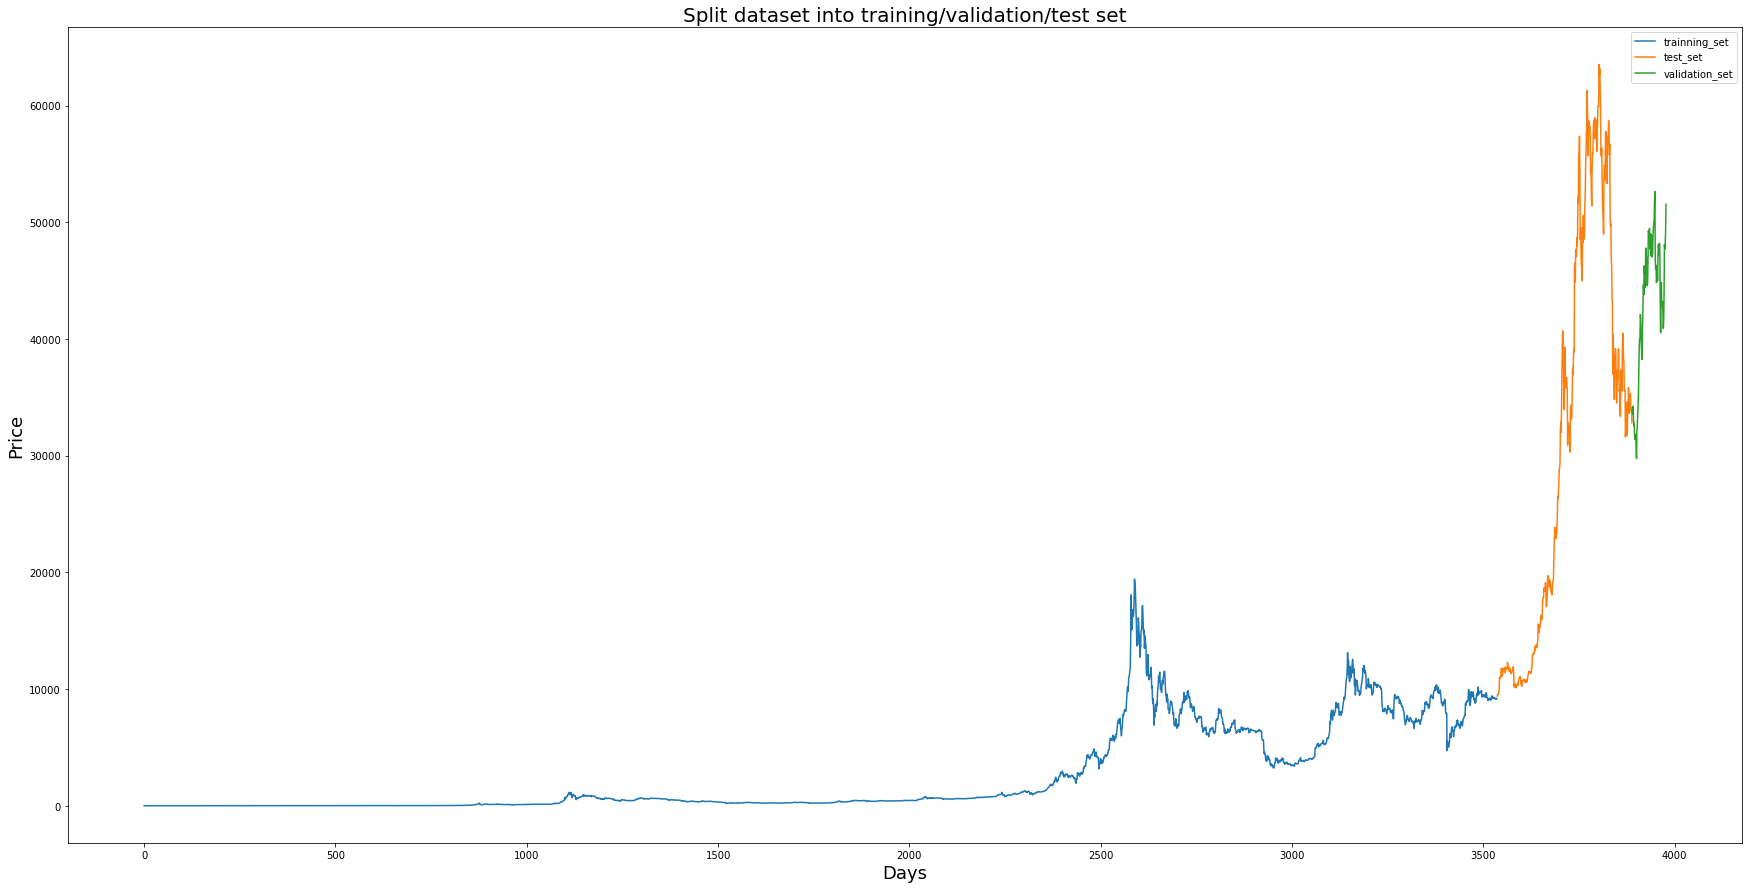

In [189]:
# PLot graph
DataSet_Graph()

### LSTM Model - Pre_work

In [190]:
# x_train and x_test were normalized already using the MinMax scaler, which is a prework requirement for LSTM
# y_train and y_test need to be scaled for the LSTM model
# y_test and y_train need to be reshaped
y_train = np.array(y_train).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)


# Fit the MinMaxScaler object with the training target data y_train
scaler = MinMaxScaler()
scaler.fit(y_train)

# Scale the target training and testing sets
y_train_scaled = scaler.transform(y_train)
y_test_scaled = scaler.transform(y_test)

### LSTM Model

In [191]:
# X_train Dataframe:
# Creating the Features (X_lstm) and Target (y_lstm) data
# This function accepts the column number for the features (X) and the target (y)
def window_data(lstm_data, window, feature_col_number, target_col_number):
    X_lstm_train = []
    y_lstm_train = []
    for i in range(len(lstm_data) - window):
        features = lstm_data.iloc[i:(i + window), feature_col_number]
        target = lstm_data.iloc[(i + window), target_col_number]
        X_lstm_train.append(features)
        y_lstm_train.append(target)
    return np.array(X_lstm_train), np.array(y_lstm_train).reshape(-1, 1)

In [192]:
# Creating the features (X) and target (y) data using the window_data() function.
window_size = 2

feature_column = 3
target_column = 3
X_lstm_train, y_lstm_train = window_data(x_train, window_size, feature_column, target_column)

In [193]:
print (f"X_lstm_training sample values:\n{X_lstm_train[:5]} \n")
print (f"y_lstm_training sample values:\n{y_lstm_train[:5]}")

X_lstm_training sample values:
[[1.02316410e-07 1.73150848e-07]
 [1.73150848e-07 1.41668876e-07]
 [1.41668876e-07 1.21205594e-07]
 [1.21205594e-07 1.02316410e-07]
 [1.02316410e-07 1.16483298e-07]] 

y_lstm_training sample values:
[[1.41668876e-07]
 [1.21205594e-07]
 [1.02316410e-07]
 [1.16483298e-07]
 [1.10186904e-07]]


In [194]:
# X_test Dataframe:
# Creating the Features (X_lstm) and Target (y_lstm) data
# This function accepts the column number for the features (X) and the target (y)
def window_data(lstm_data, window, feature_col_number, target_col_number):
    X_lstm_test = []
    y_lstm_test = []
    for i in range(len(lstm_data) - window):
        features = lstm_data.iloc[i:(i + window), feature_col_number]
        target = lstm_data.iloc[(i + window), target_col_number]
        X_lstm_test.append(features)
        y_lstm_test.append(target)
    return np.array(X_lstm_test), np.array(y_lstm_test).reshape(-1, 1)

In [195]:
# Creating the features (X) and target (y) data using the window_data() function.
window_size = 2

feature_column = 3
target_column = 3
X_lstm_test, y_lstm_test = window_data(x_test, window_size, feature_column, target_column)

In [196]:
print (f"X_lstm_testing sample values:\n{X_lstm_test[:5]} \n")
print (f"y_lstm_testing sample values:\n{y_lstm_test[:5]}")

X_lstm_testing sample values:
[[0.14773097 0.14983596]
 [0.14983596 0.15100177]
 [0.15100177 0.15024752]
 [0.15024752 0.15246816]
 [0.15246816 0.15610809]] 

y_lstm_testing sample values:
[[0.15100177]
 [0.15024752]
 [0.15246816]
 [0.15610809]
 [0.1730954 ]]


In [197]:
# Keras needs to receive the features data as a vertical vector therefore, the X data was reshaped 
# Reshape the features for the model
X_lstm_train = X_lstm_train.reshape((X_lstm_train.shape[0], X_lstm_train.shape[1], 1))
X_lstm_test = X_lstm_test.reshape((X_lstm_test.shape[0], X_lstm_test.shape[1], 1))
print (f"X_train_lstm sample values:\n{X_lstm_train[:5]} \n")
print (f"X_test_lstm sample values:\n{X_lstm_test[:5]}")

X_train_lstm sample values:
[[[1.02316410e-07]
  [1.73150848e-07]]

 [[1.73150848e-07]
  [1.41668876e-07]]

 [[1.41668876e-07]
  [1.21205594e-07]]

 [[1.21205594e-07]
  [1.02316410e-07]]

 [[1.02316410e-07]
  [1.16483298e-07]]] 

X_test_lstm sample values:
[[[0.14773097]
  [0.14983596]]

 [[0.14983596]
  [0.15100177]]

 [[0.15100177]
  [0.15024752]]

 [[0.15024752]
  [0.15246816]]

 [[0.15246816]
  [0.15610809]]]


In [198]:
# Import required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [199]:
# Define the LSTM RNN model.
model = Sequential()

number_units = 5
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_lstm_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))

In [200]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [201]:
# Summarize the model
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 2, 5)              140       
_________________________________________________________________
dropout_6 (Dropout)          (None, 2, 5)              0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 2, 5)              220       
_________________________________________________________________
dropout_7 (Dropout)          (None, 2, 5)              0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 5)                 220       
_________________________________________________________________
dropout_8 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [202]:
# Train the model
model.fit(X_lstm_train, y_lstm_train, epochs=100, shuffle=False, batch_size=32, verbose=1)

Epoch 1/100
111/111 [==============================] - 3s 4ms/step - loss: 0.0014
Epoch 2/100
111/111 [==============================] - 0s 4ms/step - loss: 0.0045
Epoch 3/100
111/111 [==============================] - 0s 4ms/step - loss: 0.0042
Epoch 4/100
111/111 [==============================] - 0s 4ms/step - loss: 0.0041
Epoch 5/100
111/111 [==============================] - 0s 4ms/step - loss: 0.0038
Epoch 6/100
111/111 [==============================] - 0s 4ms/step - loss: 0.0034
Epoch 7/100
111/111 [==============================] - 0s 4ms/step - loss: 0.0026
Epoch 8/100
111/111 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 9/100
111/111 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 10/100
111/111 [==============================] - 0s 4ms/step - loss: 7.6589e-04
Epoch 11/100
111/111 [==============================] - 0s 3ms/step - loss: 6.6674e-04
Epoch 12/100
111/111 [==============================] - 0s 3ms/step - loss: 6.1164e-04
E

### LSTM Model

In [110]:
# Evaluate the model
model_3d = model.evaluate(X_lstm_test, y_lstm_test)

11/11 [==============================] - 1s 1ms/step - loss: 0.1116


In [111]:
print (f"Loss of the Model Using 3-day window:{model_3d}" )

Loss of the Model Using 3-day window:0.11156560480594635


In [112]:
# Make some predictions
predicted_lstm = model.predict(X_lstm_test)

In [113]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted_lstm)
real_prices = scaler.inverse_transform(y_lstm_test.reshape(-1, 1))

In [114]:
# Create a DataFrame of Real and Predicted values
lstm_comparison = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
    }, index = x_train.index[-len(real_prices): ])
lstm_comparison.head()

,Real,Predicted
Date,,
2019-08-05,2933.633217,2703.755615
2019-08-06,2918.979977,2739.833984
2019-08-07,2962.121375,2752.864014
2019-08-08,3032.835732,2752.995117
2019-08-09,3362.855306,2802.655518


In [119]:
lstm_comparison.tail()

,Real,Predicted
Date,,
2020-07-16,10798.804953,5361.530762
2020-07-17,10356.656570,5387.338867
2020-07-18,10430.130181,5405.400391
2020-07-19,10356.938025,5362.243652
2020-07-20,10042.108565,5369.695801


<AxesSubplot:title={'center':'Actual Vs. Predicted Bitcoin Closing Prices Using a 3-day window'}, xlabel='Date'>

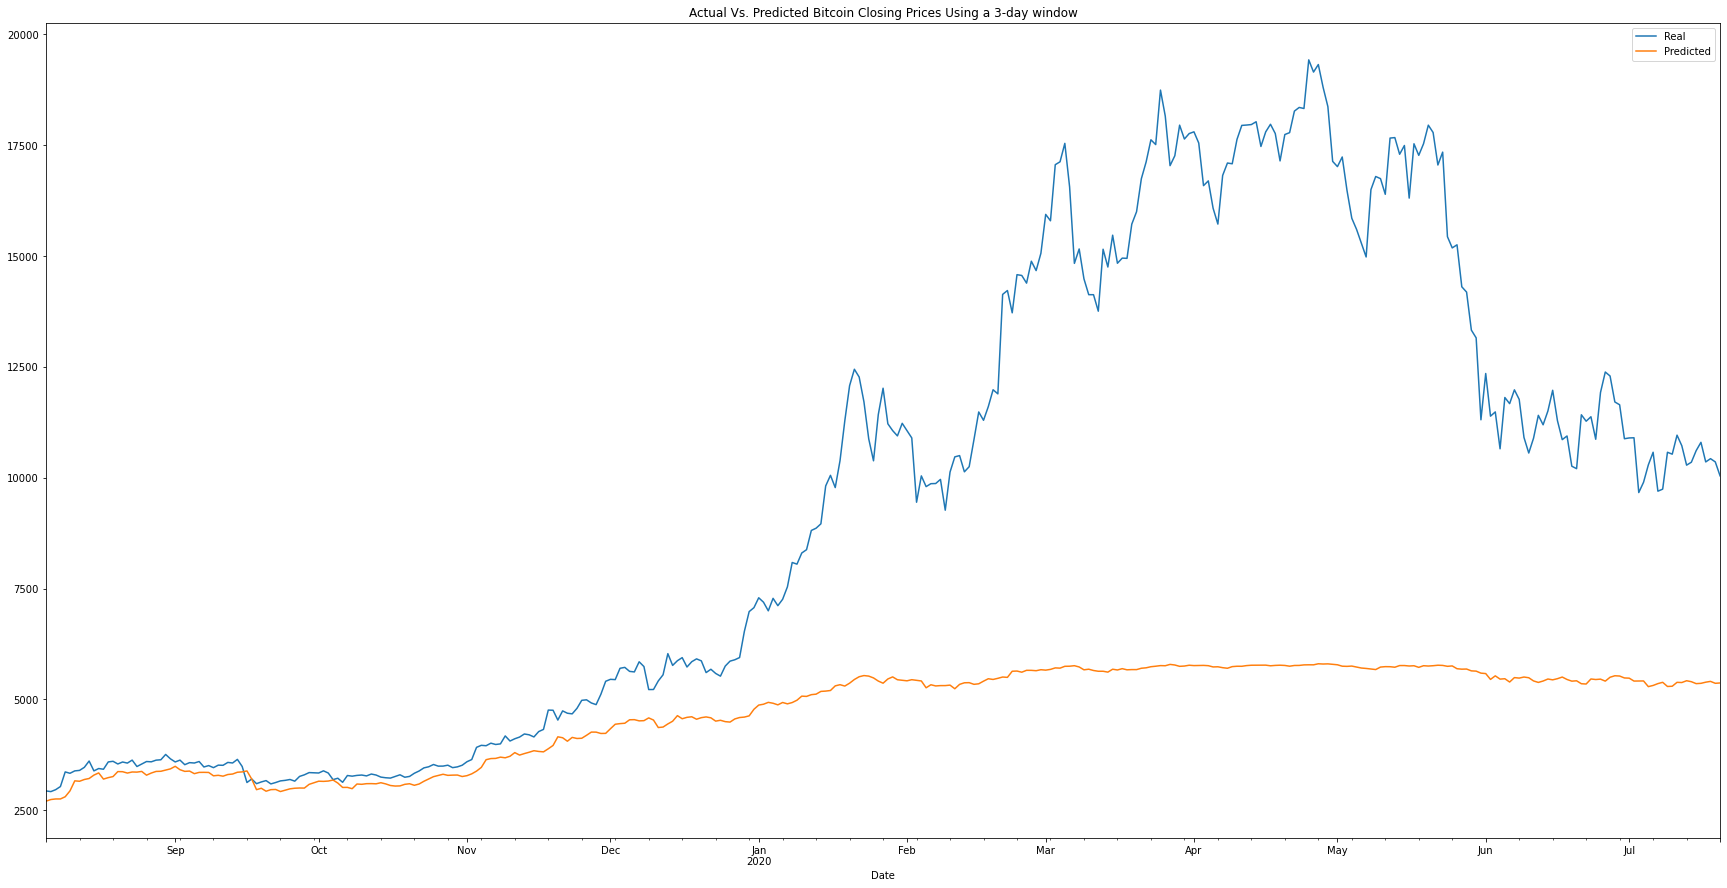

In [118]:
# Plot the real vs predicted prices as a line chart

lstm_comparison.plot(title="Actual Vs. Predicted Bitcoin Closing Prices Using a 3-day window",figsize = (30,15))

### Calculate the RMSE and R2 for later comparison:

In [130]:
# RMSE and r2 Scores for comparison
RMSE_Score_LSTM = np.sqrt(mean_squared_error(y_lstm_test, predicted_lstm))
print('RMSE score for LSTM model is', RMSE_Score_LSTM)

RMSE score for LSTM model is 0.33401438443156484


In [131]:
r2_LSTM = -r2_score(y_lstm_test, predicted_lstm)
print('r2 score for LSTM model is', r2_LSTM)

r2 score for LSTM model is 0.4869967433069202


# Run SVR, SVR Tuned, Lasso models:

In [132]:
# function for SVR
def model_SVR(x_train, y_train, validation_x):
    
    """
    This method uses svr algorithm to trian the data.
    args:
        x_train : feature training set
        y_train : target training set
        validation_x : validation feature set
    return:
        model : returns the trained model
    """
    svr_model = SVR(kernel='linear')
    model = svr_model.fit(x_train, y_train)
    return model

In [133]:
# function defining the SVR_Tuning model
def model_SVRTuning(x_train, y_train, validation_x):
    """
    This method uses svr algorithm to trian the data.
    Using different set of C and epsilon.
    Using GridSearchCV to select best hyperparameters
    args:
        x_train : feature training set
        y_train : target training set
        validation_x : validation feature set
    return:
        model : returns the trained model
    """
    hyperparameters_linearSVR = {
        'C':[0.5, 1.0, 10.0, 50.0, 100.0, 120.0,150.0, 300.0, 500.0,700.0,800.0, 1000.0],
        'epsilon':[0, 0.1, 0.5, 0.7, 0.9],
    }
    
    grid_search_SVR_feat = GridSearchCV(estimator=model_SVR(x_train, y_train, validation_x),
                           param_grid=hyperparameters_linearSVR,
                           cv=TimeSeriesSplit(n_splits=10),
    )

    model = grid_search_SVR_feat.fit(x_train, y_train)
    #print(grid_search_SVR_feat.best_params_)
    
    return model

In [135]:
# Lasso model function
def model_Lasso(x_train, y_train, validation_x):
    
    """
    This method uses to train the data.
    args:
        x_train : feature training set
        y_train : target training set
        validation_x : validation feature set
    return:
        model : returns the trained model
    """
    lasso_clf = LassoCV(n_alphas=1000, max_iter=3000, random_state=0)
    model = lasso_clf.fit(x_train,y_train)
#   prediction = model.predict(validation_x)
    return model

# Ridge model function
def model_Ridge(x_train, y_train, validation_x):
    
    """
    This method uses to train the data.
    args:
        x_train : feature training set
        y_train : target training set
        validation_x : validation feature set
    return:
        model : returns the trained model
    """
    ridge_clf = RidgeCV(gcv_mode='auto')
    model = ridge_clf.fit(x_train,y_train)
    
#   prediction = ridge_model.predict(validation_x)
    return model

In [144]:
# function 
def model_validateResult(model, model_name):
    """
    Returns RMSE_Score and R2_Score
    Also plots actual vs predicted trend
    args:
        model : the model is to validate
        model_name: name of the model
    return:
        RMSE_Score : calculates rmse score
        R2_Score : calculates R2 score
    """

    model = model(x_train, y_train, validation_x)
    prediction = model.predict(validation_x)
    RMSE_Score = np.sqrt(mean_squared_error(validation_y, prediction))
    R2_Score = r2_score(validation_y, prediction)
    
    #trendline for actual vs prediction

    plt.figure(figsize = (23,10))
    plt.plot(validation_y.index, prediction, color='green', linestyle='dashed', linewidth = 3,
         marker='o', markerfacecolor='green', markersize=8,label = 'Prediction data')
    plt.plot(validation_y.index, validation_y, color='red', linestyle='dashed', linewidth = 3,
         marker='o', markerfacecolor='red', markersize=8,label = 'Actual data')
    plt.plot(figsize = (23,10))
    plt.ylabel('Price',fontsize = 20)
    plt.xlabel('Date',fontsize = 20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.title(model_name + ' Predict vs Actual',fontsize = 20)
    plt.legend(loc='upper left')
    plt.show()
    print(model_name + ' RMSE: ', RMSE_Score)
    print(model_name + ' R2 score: ', R2_Score)
    return RMSE_Score, R2_Score

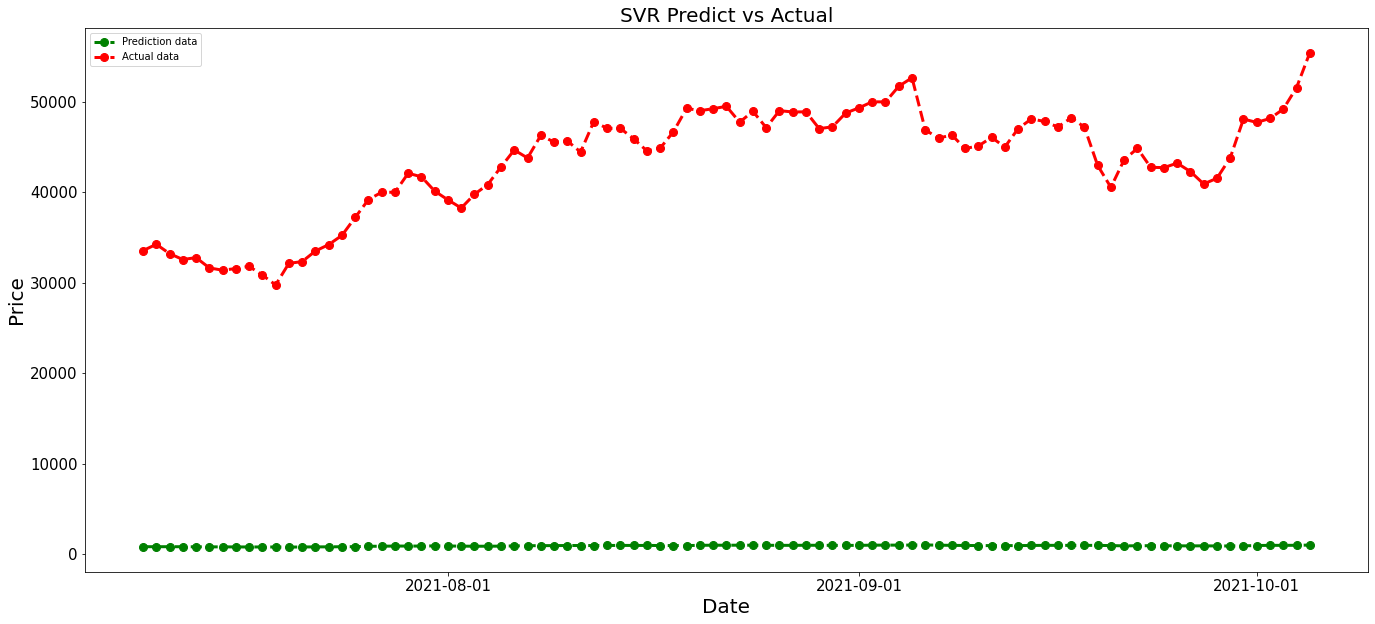

SVR RMSE:  42789.354715752335
SVR R2 score:  -48.988324880198086


In [148]:
# Run the SVR model
RMSE_Score_SVR, R2_Score_SVR = model_validateResult(model_SVR, model_name = "SVR")



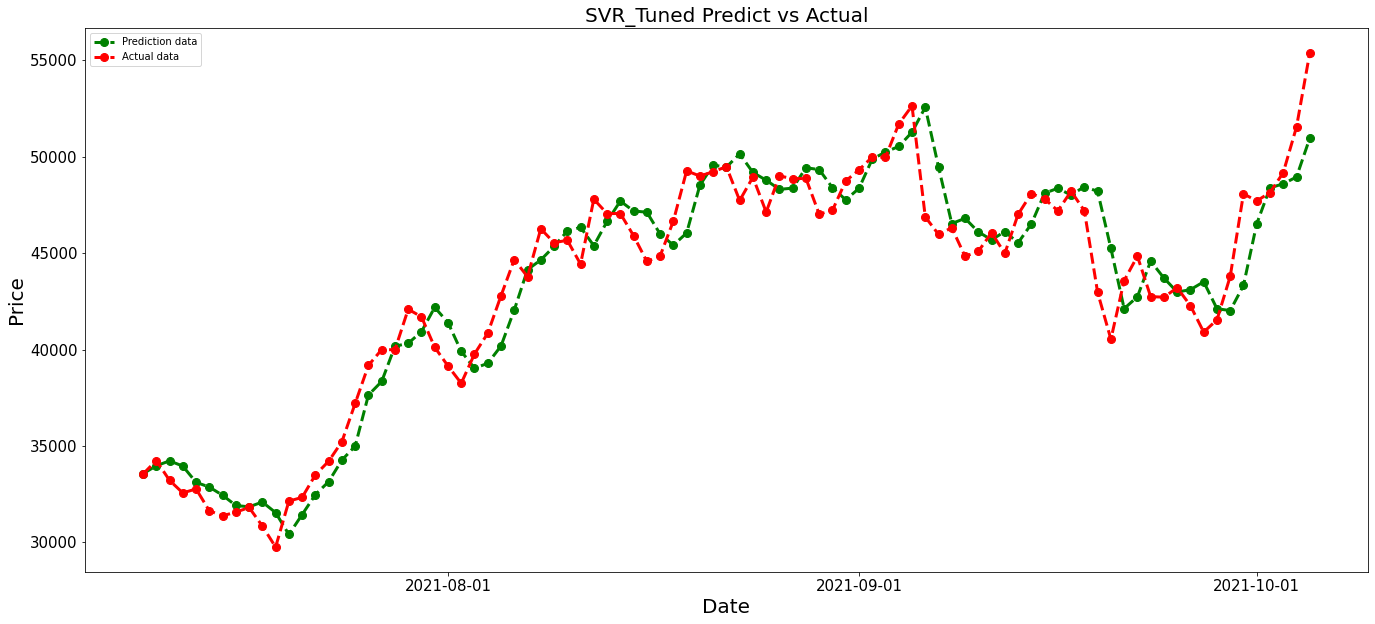

SVR_Tuned RMSE:  1827.527957830424
SVR_Tuned R2 score:  0.9088146291844788


In [149]:
# Run the SVR_Tuning Model
RMSE_Score_SVR_tuned, R2_Score_SVR_tuned = model_validateResult(model_SVRTuning, model_name = "SVR_Tuned")


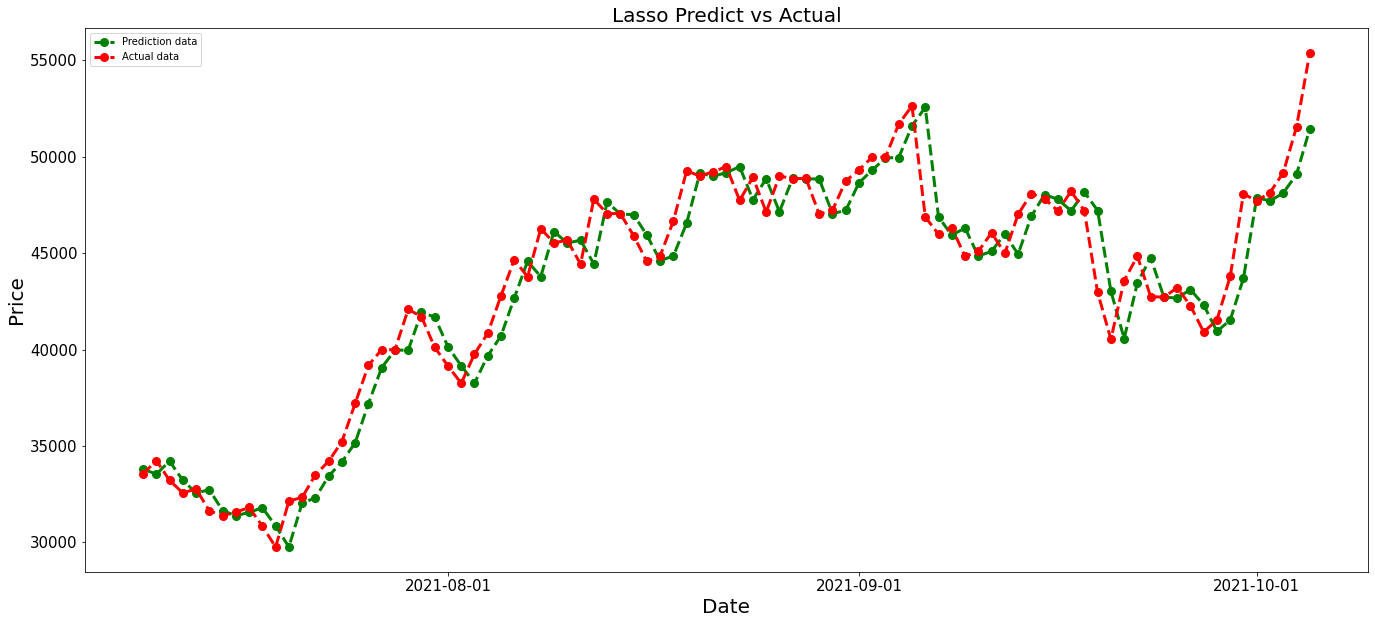

Lasso RMSE:  1625.8232587012997
Lasso R2 score:  0.9278321489008826


In [152]:
# Run the Lasso Model
RMSE_Score_Lasso, R2_Score_Lasso = model_validateResult(model_Lasso, model_name = "Lasso")


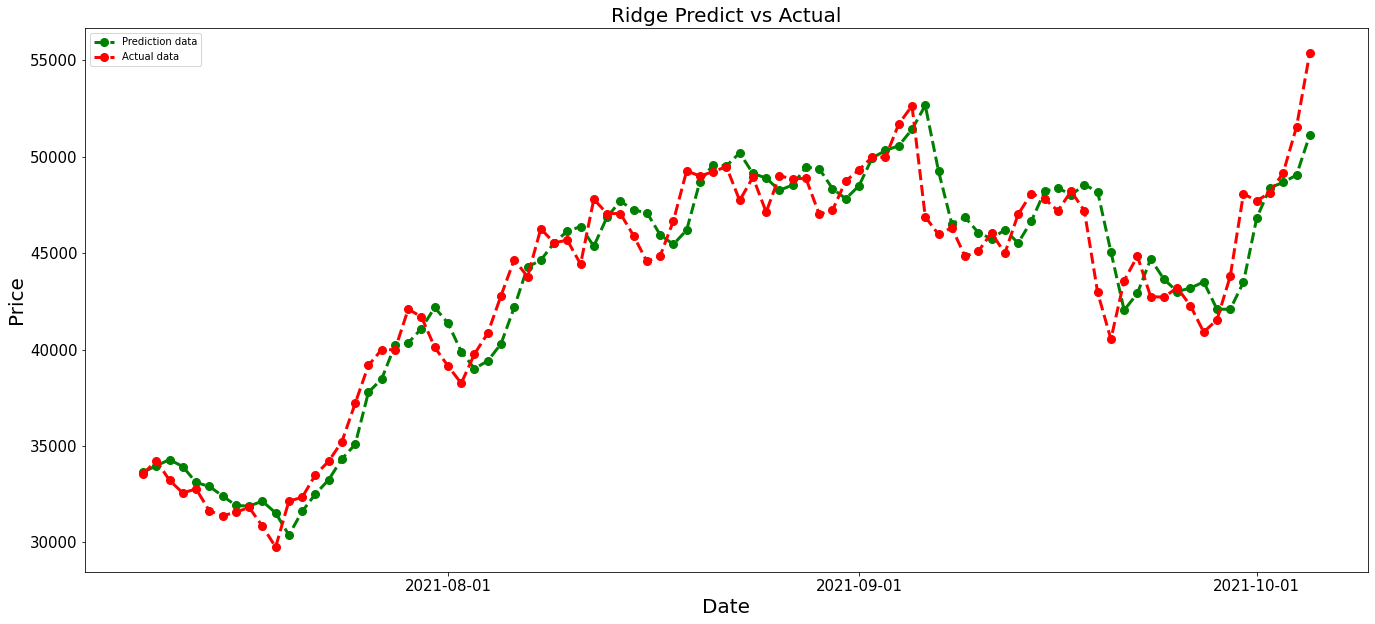

Ridge RMSE:  1792.508220112065
Ridge R2 score:  0.9122757990131386


In [153]:
# Run the Ridge Model
RMSE_Score_Ridge, R2_Score_Ridge = model_validateResult(model_Ridge, model_name = "Ridge")

## Which is the best model?

In [154]:
# Here are some functions that will help:

# Function that evaluates the models with the validation data set:
def ValidationDataResult(model, model_name):
    """
    Returns RMSE_Score and R2_Score
    Also plots actual vs predicted trend
    args:
        model : it takes the model to validate
        model_name: give the model name
    return:
        RMSE_Score : calculates rmse score
        R2_Score : calculates R2 score
    """
    model = model(x_train, y_train, validation_x)
    prediction = model.predict(validation_x)
    
    RMSE_Score = np.sqrt(mean_squared_error(validation_y, prediction))
    
    R2_Score = r2_score(validation_y, prediction)
    
    model_validation = {model_name:[RMSE_Score,R2_Score]}
    return model_validation

# Function that evaluates the models with the testing data set:
def TestDataResult(model, model_name):
    """
    Returns RMSE_Score and R2_Score
    Also plots actual vs predicted trend
    USing testing data set for evaluation
    args:
        model : it takes the model to validate
        model_name: give the model name
    return:
        RMSE_Score : calculates rmse score
        R2_Score : calculates R2 score
    """
    
    # Testing set for the evaluation 
    model = model(x_train, y_train, x_test)
    prediction = model.predict(x_test)
    
    RMSE_Score = np.sqrt(mean_squared_error(y_test, prediction))
    
    R2_Score = r2_score(y_test, prediction)
    
    model_validation_test_data = {model_name:[RMSE_Score,R2_Score]}
    
    return model_validation_test_data


In [161]:
# create a dictionary of the models that SKlearn can deal with:
model_list = {'SVR': model_SVR,'SVR_Tuning':model_SVRTuning, 'Lasso':model_Lasso,'Ridge':model_Ridge}

# Create Lists we will append to for results
ValidationData_RMSE_R2_Score = []
TestData_RMSE_R2_Score = []

# Iterate through the models and print out RMSE and R2 for validation data set:
for key, value in model_list.items():
    all_model_val = ValidationDataResult(model = value, model_name = key)
    ValidationData_RMSE_R2_Score.append(all_model_val)
print('Validation Data Result : ',ValidationData_RMSE_R2_Score)

# Iterate through the models and print out RMSE and R2 for test data set:
for key, value in model_list.items():
    all_model_val_test = TestDataResult(model = value, model_name = key)
    TestData_RMSE_R2_Score.append(all_model_val_test)


# Now we will add in the LSTM to this list for the test data set:
# first create a quick dictionary to add, containing the LSTM data:
lstm_results_dict = {'LSTM': [RMSE_Score_LSTM,r2_LSTM]}
print(lstm_results_dict)
# append to list
TestData_RMSE_R2_Score.append(lstm_results_dict)
print('Test Data Result : ', TestData_RMSE_R2_Score)


# RMSE_ValidationData,R2_Score_ValidationData,models_ValidationData = [],[],[]

# for i in ValidationData_RMSE_R2_Score:
#     for key,value in i.items():
#         RMSE_ValidationData.append(value[0])
#         R2_Score_ValidationData.append(value[1])
#         models_ValidationData.append(key)
        


# RMSE_TestData,R2_Score_TestData,models_TestData= [],[],[]

# for i in TestData_RMSE_R2_Score:
#     for key,value in i.items():
#         RMSE_TestData.append(value[0])
#         R2_Score_TestData.append(value[1])
#         models_TestData.append(key)
        
# # Create dataframes of the results data
# Validation_Model_List = pd.DataFrame(np.column_stack([RMSE_ValidationData,R2_Score_ValidationData]), index = models_ValidationData,columns = ['RMSE','R2_Score'] )
# Test_Model_List = pd.DataFrame(np.column_stack([RMSE_TestData,R2_Score_TestData]), index = models_TestData,columns = ['RMSE','R2_Score'] )

Validation Data Result :  [{'SVR': [42789.354715752335, -48.988324880198086]}, {'SVR_Tuning': [1827.527957830424, 0.9088146291844788]}, {'Lasso': [1625.8232587012997, 0.9278321489008826]}, {'Ridge': [1792.508220112065, 0.9122757990131386]}]
{'LSTM': [0.33401438443156484, 0.4869967433069202]}
Test Data Result :  [{'SVR': [34681.124989782606, -2.9602788945555525]}, {'SVR_Tuning': [752.8436962686111, 0.9981338392346093]}, {'Lasso': [63.971141872279865, 0.9999865256562208]}, {'Ridge': [689.1130743369299, 0.9984364189535317]}, {'LSTM': [0.33401438443156484, 0.4869967433069202]}]


In [162]:
Validation_Model_List

,RMSE,R2_Score
SVR,42789.354716,-48.988325
SVR_Tuning,1827.527958,0.908815
Lasso,1625.823259,0.927832
Ridge,1792.508220,0.912276


In [163]:
Test_Model_List

,RMSE,R2_Score
SVR,34681.124990,-2.960279
SVR_Tuning,752.843696,0.998134
Lasso,63.971142,0.999987
Ridge,689.113074,0.998436
LSTM,0.334014,0.486997


In [164]:
# We select lowest RMSE and Highest R2_Score to select best Model.All results indicate SVR_Tuning is the best model.
print('Min RMSE for Validation DataSet : ', Validation_Model_List['RMSE'].idxmin(),'\nMax R2_Score for Validation DataSet : ',Validation_Model_List['R2_Score'].idxmax())
print('Min RMSE for Test DataSet: ',Test_Model_List['RMSE'].idxmin(),'\nMax R2_Score for Test DataSet : ',Test_Model_List['R2_Score'].idxmax())

Min RMSE for Validation DataSet :  Lasso 
Max R2_Score for Validation DataSet :  Lasso
Min RMSE for Test DataSet:  LSTM 
Max R2_Score for Test DataSet :  Lasso


## Considering the LSTM has wildly different RMSE/R2 scores, we will not include that as an option for best fitting model (was also using Tensorflow and Keras vs. SKLearn)
## Based on what I see for the remaining models, the Lasso wins all categories with the lowest RMSE and highest R2 score for both test and validation sets.
